In [1]:
#%% appyter init
import json
import pandas as pd
import numpy as np
import pybedtools
import requests
import base64
import seaborn as sns
import matplotlib.pyplot as plt
import time
from urllib.parse import urlparse
from IPython.display import HTML, Markdown, display

from matplotlib.ticker import MaxNLocator

from appyter import magic
magic.init(lambda _=globals: _())

In [2]:
%%appyter hide_code
{% do SectionField(
    name='PRIMARY',
    title='CLIPSeq miRNA Target Discovery',
    subtitle='This appyter performs downstream analysis for miRNA-gene target discovery using CLIPSeq Data. It takes the output from dCLIP and extracts the top 500 output before performing enrichment analysis.',
    img='target.png'    
) %}

{% do SectionField(
    name='DCLIP',
    title='1. Upload dCLIP output',
    subtitle='Upload results from running dCLIP (https://qbrc.swmed.edu/softwares.php).',
    img='dclip.jpg'    
) %}

{% do SectionField(
    name='GENOME',
    title='2. Choose the genome',
    subtitle='Choose the genome used for your study, you can also upload custom bed files',
    img='dna.png'
    
) %}

{% do SectionField(
    name='ENRICHMENT',
    title='3. Choose Enrichr Libraries for Enrichment',
    subtitle='Choose libraries to use for enrichment',
    img='enrichr.png'
    
) %}

In [3]:
# helper functions
def is_url(text):
    try:
        result = urlparse(text)
        return all([result.scheme, result.netloc])
    except:
        return False

## Load input

### dCLIP output
`dCLIP_output.txt` is a tab separated file that contains information on differential binding of the samples. this is written in the state column.

**state column**:

0 refers to a bin with more binding in condition 2 than condition 1 <br>
1 refers to a bin with equal binding in both conditions <br>
2 refers to a bin with more binding in condition 1 than condition 2

In [4]:
%%appyter hide

{% set dCLIP_experiment = ChoiceField(name='dCLIP experiment',
                                  description='Condition for dCLIP',
                                  label='type of experiment',
                                  section="DCLIP",
                                  choices=['Perturbation v Negative Control', 'Perturbation v Positive Control'],
                                  default='Perturbation v Negative Control').safe_value %}

In [5]:
%%appyter hide

{% set dCLIP_output_file = FileField(
    name='dclip_output_filename',
    label='dclip output (dCLIP_output.txt)',
    default='https://appyterbucket.s3.amazonaws.com/sample_data/dCLIP_output.txt',
    section="DCLIP",
    examples={
        'GSE137071_output.txt': 'https://appyterbucket.s3.amazonaws.com/sample_data/dCLIP_output.txt'
    }
) %}

In [6]:
%%appyter code_exec
dCLIP_experiment = "{{ dCLIP_experiment }}"
dCLIP_output_file = {{ dCLIP_output_file }}

```python
dCLIP_experiment = "Perturbation v Negative Control"
dCLIP_output_file = 'https://appyterbucket.s3.amazonaws.com/sample_data/dCLIP_output.txt'
```

In [7]:
dclip_output = pd.read_csv(dCLIP_output_file, sep="\t")
dclip_output.head()

,id,chrom,strand,position,state,probability,differential,tag1,mut1,tag2,mut2
0,1,chr7,-,152085,1,0.998338,-0.095310,0,0,1,0
1,1,chr7,-,152090,1,0.684900,-0.470004,0,0,6,0
2,1,chr7,-,152095,0,0.705606,-0.693147,0,0,10,0
3,1,chr7,-,152100,0,0.907399,-0.788457,0,0,12,0
4,1,chr7,-,152105,0,0.979348,-0.916291,0,0,15,0


### dCLIP_summary.bed

`dCLIP_summay.bed` contains the summary of the inference results. We note the following columns:

**Column 3**: Cluster id <br>
**Column 4**: "The fifth column is the average binding strength of condition 1 in this continuous region if in state 2, the average binding strength of condition 2 if in state 0 and 0 if in state 1"

In [8]:
%%appyter hide

{% set dCLIP_summary_file = FileField(
    name='dclip_summary_filename',
    label='dclip output (dCLIP_summary.bed)',
    default='https://appyterbucket.s3.amazonaws.com/sample_data/dCLIP_summary.bed',
    section="DCLIP",
    description='Upload dCLIP_summary.bed',
    examples={
        'GSE137071_summary.bed': 'https://appyterbucket.s3.amazonaws.com/sample_data/dCLIP_summary.bed'
    }
) %}


In [9]:
%%appyter code_exec

dCLIP_summary_file = {{ dCLIP_summary_file }}

```python

dCLIP_summary_file = 'https://appyterbucket.s3.amazonaws.com/sample_data/dCLIP_summary.bed'
```

In [10]:
if is_url(dCLIP_summary_file):
    res = requests.get(dCLIP_summary_file)
    if res.ok:
        dCLIP_summary_file = res.text
        dCLIP_summary = pybedtools.BedTool(dCLIP_summary_file, from_string=True).saveas("dCLIP_summary.bed")
else:
    dCLIP_summary = pybedtools.BedTool(dCLIP_summary_file)
dCLIP_summary.head()

track	name="dCLIP_summary"	description="dCLIP_summary"	itemRgb="On"
 chr7	152085	152094	1	0	-	152085	152094	0,255,0
 chr7	152095	152164	1	2	-	152095	152164	255,0,0
 chr7	152165	152234	1	0	-	152165	152234	0,255,0
 chrUn	250	314	2	0	-	250	314	0,255,0
 chrUn	315	404	3	2	-	315	404	0,0,255
 chrUn	405	419	3	0	-	405	419	0,255,0
 chrUn	1160	1324	4	0	-	1160	1324	0,255,0
 chr5	119685	119719	5	5	+	119685	119719	0,0,255
 chr5	163385	163414	6	4	+	163385	163414	255,0,0
 

#### Number of clusters

In [11]:
len(dclip_output.id.unique())

121118

In [12]:
dclip_output["pos_concat"] = dclip_output.id.astype(str) + dclip_output.chrom.astype(str) + dclip_output.position.astype(str)

In [13]:
%%appyter code_exec
top_ranked = {{IntField(name='TopGenes', label='Top Genes', min=50, max=1000, default=500, section='DCLIP')}}

```python

top_ranked = 500
```

## Genome files
We load the bed files for the whole genes and 3' UTR as well as the gene name mapper

In [14]:
%%appyter code_exec
genome_type = "{{ ChoiceField(name='Genome',description='Name of Genome',label='Genome',choices=['UCSC human (hg38)', 'UCSC mouse (mm10)', 'custom'],default='UCSC human (hg38)',section='GENOME').safe_value }}"

whole_gene_bed_file = "{{ FileField(name='whole_gene_bed_filename',label='Custom Whole Gene Bed File (Optional)',default='',description='Bed file for whole genes',section='GENOME').value }}"

utr_gene_bed_file = "{{ FileField(name='utr_gene_bed_filename',label='3 UTR Bed File (Optional)',default='',description='Custom Bed file for 3 UTR',section='GENOME').value }}"

gene_name_map_file = "{{ FileField(name='gene_name_map_file',label='Gene Mapping File (Optional)',default='',description='Custom Gene name mapper (Optional)',section='GENOME').value }}"

```python
genome_type = "UCSC human (hg38)"
whole_gene_bed_file = ""
utr_gene_bed_file = ""
gene_name_map_file = ""
```

In [15]:
if genome_type == "custom":
    bed_wholegenes = pybedtools.BedTool(whole_gene_bed_file)
    bed_3UTR = pybedtools.BedTool(utr_gene_bed_file)
    gene_names = pd.read_csv(gene_name_map_file, sep="\t", index_col=0).to_dict()["name2"]
else:
    if genome_type == "UCSC mouse (mm10)":
        whole_gene_bed_file = "https://appyterbucket.s3.amazonaws.com/mm10/mm10.wholegenes.bed"
        utr_gene_bed_file = "https://appyterbucket.s3.amazonaws.com/mm10/mm10.3UTR.bed"
        gene_name_map_file = "https://appyterbucket.s3.amazonaws.com/mm10/mm10.gene_name.tsv"
    elif genome_type == "UCSC human (hg38)":
        whole_gene_bed_file = "https://appyterbucket.s3.amazonaws.com/hg38/hg38.wholegenes.bed"
        utr_gene_bed_file = " https://appyterbucket.s3.amazonaws.com/hg38/hg38.3utr.bed"
        gene_name_map_file = "https://appyterbucket.s3.amazonaws.com/hg38/hg38.gene_name.tsv"
    
    res = requests.get(whole_gene_bed_file)
    if res.ok:
        bed_wholegenes = pybedtools.BedTool(res.text, from_string=True).saveas("wholegenes.bed")
    else:
        raise Exception(res.text)
    res = requests.get(utr_gene_bed_file)
    if res.ok:
        bed_3UTR = pybedtools.BedTool(res.text, from_string=True).saveas("3UTR.bed")
    else:
        raise Exception(res.text)
    gene_names = pd.read_csv(gene_name_map_file, sep="\t", index_col=0).to_dict()["name2"]

## Extract differentially binding clusters
Targets in the positive samples should have higher peaks than those in negative samples. Recall that:

**state column**:

0 refers to a bin with more binding in condition 2 than condition 1 <br>
1 refers to a bin with equal binding in both conditions <br>
2 refers to a bin with more binding in condition 1 than condition 2

In [16]:
state = 0 if dCLIP_experiment == "Perturbation v Positive Control" else 2
pos_clusters = dclip_output[dclip_output.state==state]
pos_clusters.head().loc[:,pos_clusters.columns != "pos_concat"]

,id,chrom,strand,position,state,probability,differential,tag1,mut1,tag2,mut2
43,3,chrUn,-,315,2,0.730137,0.148585,1,0,0,0
44,3,chrUn,-,320,2,0.792474,0.588320,5,0,0,0
45,3,chrUn,-,325,2,0.841428,0.588320,5,0,0,0
46,3,chrUn,-,330,2,0.880093,0.588320,5,0,0,0
47,3,chrUn,-,335,2,0.910909,0.588320,5,0,0,0


#### Number of clusters

In [17]:
len(pos_clusters.id.unique())

42568

## Get positive clusters only bed file

In [18]:
pos_concat = set(pos_clusters.pos_concat)
def filter_pos(features):
    position = str(features.start)
    cluster_id = str(features.name)
    chrom = str(features.chrom)
    pos = "%s%s%s"%(cluster_id,chrom,position)
    if pos in pos_concat:
        return True
    else:
        return False

In [19]:
pos_only = dCLIP_summary.filter(filter_pos).saveas("pos_only.bed", trackline='track name="positive"')

In [20]:
clusters = set(pos_clusters.id)
def filter_pos_whole(features):
    cluster_id = str(features.name)
    if cluster_id in clusters:
        return True
    else:
        return False

In [21]:
# We'll use this later
pos_whole_gene = dCLIP_summary.filter(filter_pos_whole).saveas("pos_whole.bed", trackline='track name="pos whole"')

## Find clusters enriched in the 3'UTR

To narrow our targets, we only select those that with differential peaks in the 3' UTR

In [22]:
pos_3UTR = pos_only.intersect(bed_3UTR, s=True).saveas("intersection.bed", trackline='track name="pos 3UTR intersection"')

In [23]:
len(pos_3UTR)

38191

## Get gene ids
Using the whole genes bed file, we extract the gene ids

In [24]:
gene_ids = pos_3UTR.intersect(bed_wholegenes, wa=True, wb=True, s=True).to_dataframe(header=None, names=range(21))

In [25]:
gene_ids.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,chr5,314585,314614,45,1,+,314585,314614,"0,0,255",chr5,...,314974,NM_001267558.1,0,+,306603,314515,0,7,"70,46,62,45,159,110,558,","0,155,1090,32556,34981,39672,42796,"
1,chr5,314585,314614,45,1,+,314585,314614,"0,0,255",chr5,...,314974,NM_001267557.1,0,+,271720,314515,0,4,"201,62,110,558,","0,1090,39672,42796,"
2,chr5,314585,314614,45,1,+,314585,314614,"0,0,255",chr5,...,314974,NM_001267559.2,0,+,271720,314418,0,4,"176,62,45,558,","0,1065,32531,42771,"
3,chr5,314585,314614,45,1,+,314585,314614,"0,0,255",chr5,...,314974,NM_001267556.2,0,+,271720,314515,0,6,"176,62,45,153,110,558,","0,1065,32531,34956,39647,42771,"
4,chr5,314585,314614,45,1,+,314585,314614,"0,0,255",chr5,...,314974,NM_013232.4,0,+,271720,314515,0,6,"176,62,45,159,110,558,","0,1065,32531,34956,39647,42771,"


In [26]:
sorted_bed = gene_ids.sort_values(by=[4], ascending=False)

In [27]:
sorted_bed.head(20)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
147234,chr5,116443985,116444069,40531,64,-,116443985,116444069,"0,0,255",chr5,...,116574823,NM_001300780.2,0,-,116446612,116504944,0,20,"4257,165,51,21,59,81,141,177,156,132,218,89,12...","0,24028,29330,29518,31990,34291,34459,34987,36..."
147243,chr5,116443985,116444069,40531,64,-,116443985,116444069,"0,0,255",chr5,...,116574823,NM_020796.5,0,-,116446612,116504944,0,19,"4257,165,21,59,81,141,177,156,132,218,89,120,9...","0,24028,29518,31990,34291,34459,34987,36567,38..."
147229,chr5,116443985,116444069,40531,64,-,116443985,116444069,"0,0,255",chr5,...,116574598,XM_006714663.2,0,-,116446612,116504944,0,20,"4257,165,66,21,59,81,141,177,156,132,218,89,12...","0,24028,25295,29518,31990,34291,34459,34987,36..."
147230,chr5,116443985,116444069,40531,64,-,116443985,116444069,"0,0,255",chr5,...,116574823,NM_001300780.2,0,-,116446612,116504944,0,20,"4257,165,51,21,59,81,141,177,156,132,218,89,12...","0,24028,29330,29518,31990,34291,34459,34987,36..."
147231,chr5,116443985,116444069,40531,64,-,116443985,116444069,"0,0,255",chr5,...,116574823,NM_020796.5,0,-,116446612,116504944,0,19,"4257,165,21,59,81,141,177,156,132,218,89,120,9...","0,24028,29518,31990,34291,34459,34987,36567,38..."
147232,chr5,116443985,116444069,40531,64,-,116443985,116444069,"0,0,255",chr5,...,116536428,XM_017009675.1,0,-,116446612,116504944,0,20,"4257,165,66,21,59,81,141,177,156,132,218,89,12...","0,24028,25295,29518,31990,34291,34459,34987,36..."
147233,chr5,116443985,116444069,40531,64,-,116443985,116444069,"0,0,255",chr5,...,116574598,XM_006714663.2,0,-,116446612,116504944,0,20,"4257,165,66,21,59,81,141,177,156,132,218,89,12...","0,24028,25295,29518,31990,34291,34459,34987,36..."
147235,chr5,116443985,116444069,40531,64,-,116443985,116444069,"0,0,255",chr5,...,116574823,NM_020796.5,0,-,116446612,116504944,0,19,"4257,165,21,59,81,141,177,156,132,218,89,120,9...","0,24028,29518,31990,34291,34459,34987,36567,38..."
147236,chr5,116443985,116444069,40531,64,-,116443985,116444069,"0,0,255",chr5,...,116536428,XM_017009675.1,0,-,116446612,116504944,0,20,"4257,165,66,21,59,81,141,177,156,132,218,89,12...","0,24028,25295,29518,31990,34291,34459,34987,36..."
147237,chr5,116443985,116444069,40531,64,-,116443985,116444069,"0,0,255",chr5,...,116574598,XM_006714663.2,0,-,116446612,116504944,0,20,"4257,165,66,21,59,81,141,177,156,132,218,89,12...","0,24028,25295,29518,31990,34291,34459,34987,36..."


In [28]:
display(Markdown("## Top %d genes"%top_ranked))

## Top 500 genes

In [29]:
ranked_genes = []
indices = []
for i in sorted_bed[12].index:
    gene_id = sorted_bed[12][i]
    gene = gene_names[gene_id]
    if gene not in ranked_genes:
        ranked_genes.append(gene)
        indices.append(i)
        sorted_bed.loc[i,12] = gene
    if len(ranked_genes) == top_ranked:
        break

In [30]:
top_genes = sorted_bed.loc[indices]

In [31]:
scores = pd.DataFrame(columns=["chrom","start", "end", "name", "average binding strenth", "strand", "gene name"])
for i in top_genes.index:
    row = pd.Series(list(top_genes.loc[i][0:6]) + [top_genes.loc[i,12]], index=["chrom","start", "end", "name", "average binding strenth", "strand", "gene name"])
    row_frame = pd.DataFrame([row])
    scores = pd.concat([scores,row_frame], sort=False, ignore_index=True)
scores.head()

,chrom,start,end,name,average binding strenth,strand,gene name
0,chr5,116443985,116444069,40531,64,-,SEMA6A
1,chr7,128769270,128769364,16253,62,+,CALU
2,chr7,130505445,130505494,16342,49,+,MEST
3,chr1,43622003,43622049,79225,48,+,PTPRF
4,chrX,129647395,129647429,98733,45,-,APLN


## Download Files

In [32]:
# https://stackoverflow.com/questions/31893930/download-csv-from-an-ipython-notebook
def create_download_link(csv_string, title = "Download CSV file", filename = "data.csv"):
    b64 = base64.b64encode(csv_string.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [33]:
create_download_link(scores.to_csv(), title = "Download Top %d Dataframe"%top_ranked, filename = "top500.csv")

In [34]:
create_download_link("\n".join(ranked_genes), title = "Download Top %d genes"%top_ranked, filename = "top500.txt")

## Enrichment

In [35]:
ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr'
def enrichr_add_list(enrichr_gene_list, description):
    genes_str = '\n'.join(enrichr_gene_list)
    payload = {
        'list': (None, genes_str),
        'description': (None, description)
    }

    response = requests.post(ENRICHR_URL + "/addList", files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')
    return json.loads(response.text)

# Adapted from Megan's Appyter (https://github.com/MaayanLab/appyter-catalog/tree/master/appyters/Enrichr_compressed_bar_chart_figure)
def enrich(library_name, user_list_id, short_id):
    all_terms = []
    all_pvalues =[] 
    all_adjusted_pvalues = []
    time.sleep(0.5)
    response = requests.get(
        ENRICHR_URL + "/enrich", params={
            "userListId": user_list_id,
            "backgroundType": library_name
        }
     )
    if not response.ok:
        raise Exception('Error fetching enrichment results')

    data = json.loads(response.text)

    results_df  = pd.DataFrame(data[library_name][0:10])
    all_terms.append(list(results_df[1]))
    all_pvalues.append(list(results_df[2]))
    all_adjusted_pvalues.append(list(results_df[6]))

    return([all_terms,all_pvalues,all_adjusted_pvalues,str(short_id)])

# Megan's code
annot_dict = {}
# Function plots results 
# Takes all terms, all p-values, all adjusted p-values, plot title, Enrichr libraries , and specified figure format
def enrichr_figure(all_terms,all_pvalues, all_adjusted_pvalues, plot_names, all_libraries, fig_format, bar_color): 
    
    # rows and columns depend on number of Enrichr libraries submitted 
    rows = []
    cols = []
    
    # Bar colors
    if bar_color!= 'lightgrey':
        bar_color_not_sig = 'lightgrey'
        edgecolor=None
        linewidth=0
    else:
        bar_color_not_sig = 'white'
        edgecolor='black'
        linewidth=1
    
    # If only 1 Enrichr library selected, make simple plot 
    if len(all_libraries)==1:
        #fig,axes = plt.subplots(1, 1,figsize=[8.5,6])
        plt.figure(figsize=(10,4))
        rows = [0]
        cols = [0]
        i = 0 
        bar_colors = [bar_color if (x < 0.05) else bar_color_not_sig for x in all_pvalues[i]]
        fig = sns.barplot(x=np.log10(all_pvalues[i])*-1, y=all_terms[i], palette=bar_colors, edgecolor=edgecolor, linewidth=linewidth)
        fig.axes.get_yaxis().set_visible(False)
        fig.set_title(all_libraries[i].replace('_',' '),fontsize=26)
        fig.set_xlabel('-Log10(p-value)',fontsize=25)
        fig.xaxis.set_major_locator(MaxNLocator(integer=True))
        fig.tick_params(axis='x', which='major', labelsize=20)
        if max(np.log10(all_pvalues[i])*-1)<1:
            fig.xaxis.set_ticks(np.arange(0, max(np.log10(all_pvalues[i])*-1), 0.1))
        for ii,annot in enumerate(all_terms[i]):
            if annot in annot_dict.keys():
                annot = annot_dict[annot]
            if all_adjusted_pvalues[i][ii] < 0.05:
                annot = '  *'.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii],precision=2)))]) 
            else:
                annot = '  '.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii],precision=2)))])

            title_start= max(fig.axes.get_xlim())/200
            fig.text(title_start,ii,annot,ha='left',wrap = True, fontsize = 12)
            fig.patch.set_edgecolor('black')  
            fig.patch.set_linewidth('2')
        
    
    # If there are an even number of Enrichr libraries below 6
    # Plots 1x2 or 2x2
    else:
        if len(all_libraries) % 2 == 0 and len(all_libraries) < 5:
                for i in range(0,int(len(all_libraries)/2)):    
                    rows = rows + [i]*2
                    cols = list(range(0,2))*int(len(all_libraries)/2)    
                fig, axes = plt.subplots(len(np.unique(rows)), len(np.unique(cols)),figsize=[7,int(2* len(np.unique(rows)))]) 
    
        
        # All other # of libraries 6 and above will have 3 columns and a flexible number of rows to accomodate all plots
        else:
            for i in range(0,int(np.ceil(len(all_libraries)/3))):
                rows = rows + [i]*3
                cols = list(range(0,3))*int(np.ceil(len(all_libraries)/3))
            fig, axes = plt.subplots(len(np.unique(rows)), len(np.unique(cols)),figsize=[8,int(2* len(np.unique(rows)))])
           
        # If final figure only has one row...
        if len(np.unique(rows))==1:
            for i,library_name in enumerate(all_libraries):
                bar_colors = [bar_color if (x < 0.05) else bar_color_not_sig for x in all_pvalues[i]]
                sns.barplot(x=np.log10(all_pvalues[i])*-1, y=all_terms[i],ax=axes[i], palette=bar_colors, edgecolor=edgecolor, linewidth=linewidth)
                axes[i].axes.get_yaxis().set_visible(False)
                axes[i].set_title(library_name.replace('_',' '),fontsize=36)
                axes[i].set_xlabel('-Log10(p-value)',fontsize=35)
                axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))
                axes[i].tick_params(axis='x', which='major', labelsize=30)
                if max(np.log10(all_pvalues[i])*-1)<1:
                    axes[i].xaxis.set_ticks(np.arange(0, max(np.log10(all_pvalues[i])*-1), 0.1))
                for ii,annot in enumerate(all_terms[i]):
                    if annot in annot_dict.keys():
                        annot = annot_dict[annot]
                    if all_adjusted_pvalues[i][ii] < 0.05:
                        annot = '  *'.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii],precision=2)))]) 
                    else:
                        annot = '  '.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii],precision=2)))])

                    title_start= max(axes[i].axes.get_xlim())/200
                    axes[i].text(title_start,ii,annot,ha='left',wrap = True, fontsize = 36)
                    axes[i].patch.set_edgecolor('black')  
                    axes[i].patch.set_linewidth('2')

            plt.subplots_adjust(top=4.5, right = 4.7,wspace = 0.03,hspace = 0.2)


        # If the final figure has more than one row...
        else:


            for i,library_name in enumerate(all_libraries):
                bar_colors = [bar_color if (x < 0.05) else bar_color_not_sig for x in all_pvalues[i]]
                sns.barplot(x=np.log10(all_pvalues[i])*-1, y=all_terms[i],ax=axes[rows[i],cols[i]], palette=bar_colors, edgecolor=edgecolor, linewidth=linewidth)
                axes[rows[i],cols[i]].axes.get_yaxis().set_visible(False)
                axes[rows[i],cols[i]].set_title(library_name.replace('_',' '),fontsize=36)
                axes[rows[i],cols[i]].set_xlabel('-Log10(p-value)',fontsize=35)
                axes[rows[i],cols[i]].xaxis.set_major_locator(MaxNLocator(integer=True))
                axes[rows[i],cols[i]].tick_params(axis='x', which='major', labelsize=30)
                if max(np.log10(all_pvalues[i])*-1)<1:
                    axes[rows[i],cols[i]].xaxis.set_ticks(np.arange(0, max(np.log10(all_pvalues[i])*-1), 0.1))
                for ii,annot in enumerate(all_terms[i]):
                    if annot in annot_dict.keys():
                        annot = annot_dict[annot]
                    if all_adjusted_pvalues[i][ii] < 0.05:
                        annot = '  *'.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii],precision=2)))]) 
                    else:
                        annot = '  '.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii],precision=2)))])

                    title_start= max(axes[rows[i],cols[i]].axes.get_xlim())/200
                    axes[rows[i],cols[i]].text(title_start,ii,annot,ha='left',wrap = True, fontsize = 36)
                    axes[rows[i],cols[i]].patch.set_edgecolor('black')  
                    axes[rows[i],cols[i]].patch.set_linewidth('2')

            plt.subplots_adjust(top=4.8, right = 4.7,wspace = 0.03,hspace = 0.2)


        # If >6 libraries are chosen and is not a multiple of 3, delete empty plots
        if len(np.unique(rows))*len(np.unique(cols)) != len(all_libraries):
            diff = (len(np.unique(rows))*len(np.unique(cols))) - len(all_libraries)
            for i in range (1,int(diff+1)):
                fig.delaxes(axes[rows[-i]][cols[-i]])
    
    # Save results 
    for plot_name in plot_names:
        plt.savefig(plot_name,bbox_inches = 'tight')
    
    # Show plot 
    plt.show()

In [36]:
%%appyter code_exec

transcription_libraries = {{ MultiChoiceField(name='transcription_libraries', description='Select the Enrichr libraries you would like in your figure.', label='Transcription', default=[], section = 'ENRICHMENT',choices=[
    'ARCHS4_TFs_Coexp',
    'ChEA_2016',
    'ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X',
    'ENCODE_Histone_Modifications_2015',
    'ENCODE_TF_ChIP-seq_2015',
    'Epigenomics_Roadmap_HM_ChIP-seq',
    'Enrichr_Submissions_TF-Gene_Coocurrence',
    'Genome_Browser_PWMs',
    'lncHUB_lncRNA_Co-Expression',
    'miRTarBase_2017',
    'TargetScan_microRNA_2017',
    'TF-LOF_Expression_from_GEO',
    'TF_Perturbations_Followed_by_Expression',
    'Transcription_Factor_PPIs',
    'TRANSFAC_and_JASPAR_PWMs',
    'TRRUST_Transcription_Factors_2019']) }}


pathways_libraries = {{ MultiChoiceField(name='pathways_libraries', description='Select the Enrichr libraries you would like in your figure.', label='Pathways', default=[], section = 'ENRICHMENT',choices=[
    'ARCHS4_Kinases_Coexp',
    'BioCarta_2016',
    'BioPlanet_2019',
    'BioPlex_2017',
    'CORUM',
    'Elsevier_Pathway_Collection',
    'HMS_LINCS_KinomeScan',
    'HumanCyc_2016',
    'huMAP',
    'KEA_2015',
    'KEGG_2019_Human',
    'KEGG_2019_Mouse',
    'Kinase_Perturbations_from_GEO_down',
    'Kinase_Perturbations_from_GEO_up',
    'L1000_Kinase_and_GPCR_Perturbations_down',
    'L1000_Kinase_and_GPCR_Perturbations_up',
    'NCI-Nature_2016',
    'NURSA_Human_Endogenous_Complexome',
    'Panther_2016',
    'Phosphatase_Substrates_from_DEPOD',
    'PPI_Hub_Proteins',
    'Reactome_2016',
    'SILAC_Phosphoproteomics',
    'SubCell_BarCode',
    'Virus-Host_PPI_P-HIPSTer_2020',
    'WikiPathways_2019_Human',
    'WikiPathways_2019_Mouse']) }}    
    
  
ontologies_libraries = {{ MultiChoiceField(name='ontologies_libraries', description='Select the Enrichr libraries you would like in your figure.', label='Ontologies', default=[], section = 'ENRICHMENT',choices=[
    'GO_Biological_Process_2018',
    'GO_Cellular_Component_2018',
    'GO_Molecular_Function_2018',
    'Human_Phenotype_Ontology',
    'Jensen_COMPARTMENTS',
    'Jensen_DISEASES',
    'Jensen_TISSUES',
    'MGI_Mammalian_Phenotype_Level_4_2019']) }} 

    
diseases_drugs_libraries = {{ MultiChoiceField(name='diseases_drugs_libraries', description='Select the Enrichr libraries you would like in your figure.', label='Diseases/Drugs', default=[], section = 'ENRICHMENT',choices=[    
    'Achilles_fitness_decrease',
    'Achilles_fitness_increase',
    'ARCHS4_IDG_Coexp',
    'ClinVar_2019',
    'dbGaP',
    'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
    'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
    'DisGeNET',
    'DrugMatrix',
    'DSigDB',
    'GeneSigDB',
    'GWAS_Catalog_2019',
    'LINCS_L1000_Chem_Pert_down',
    'LINCS_L1000_Chem_Pert_up',
    'LINCS_L1000_Ligand_Perturbations_down',
    'LINCS_L1000_Ligand_Perturbations_up',
    'MSigDB_Computational',
    'MSigDB_Oncogenic_Signatures',
    'Old_CMAP_down',
    'Old_CMAP_up',
    'OMIM_Disease',
    'OMIM_Expanded',
    'PheWeb_2019',
    'Rare_Diseases_AutoRIF_ARCHS4_Predictions',
    'Rare_Diseases_AutoRIF_Gene_Lists',
    'Rare_Diseases_GeneRIF_ARCHS4_Predictions',
    'Rare_Diseases_GeneRIF_Gene_Lists',
    'UK_Biobank_GWAS_v1',
    'Virus_Perturbations_from_GEO_down',
    'Virus_Perturbations_from_GEO_up',
    'VirusMINT']) }}

```python
transcription_libraries = []
pathways_libraries = []
ontologies_libraries = []
diseases_drugs_libraries = []
```

In [37]:
enrichment_libraries = transcription_libraries + pathways_libraries + ontologies_libraries + diseases_drugs_libraries or ['KEGG_2019_Human', 'Reactome_2016','GO_Biological_Process_2018', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018']

In [38]:
description = 'top %d targets'%top_ranked

data = enrichr_add_list(ranked_genes, description)
user_list_id = data['userListId']
short_id = data["shortId"]

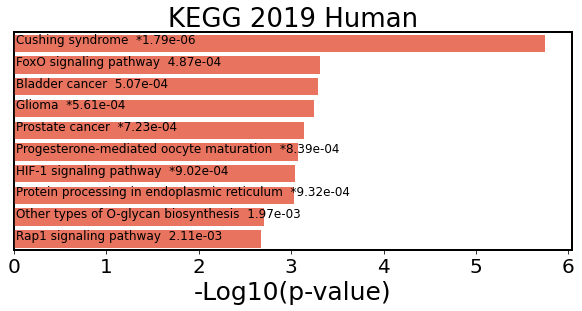

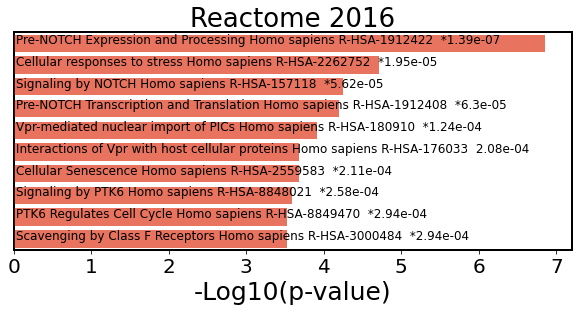

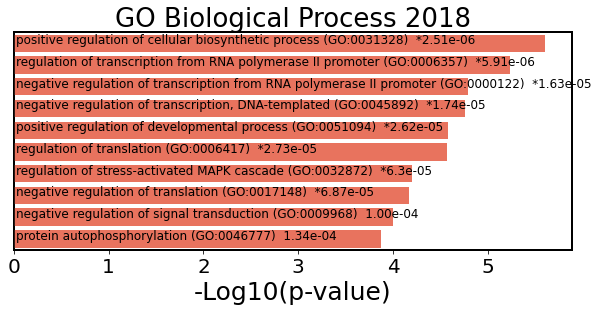

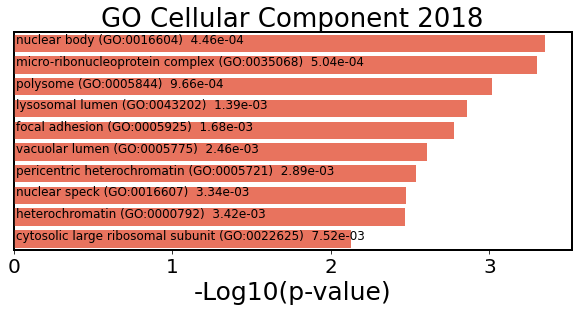

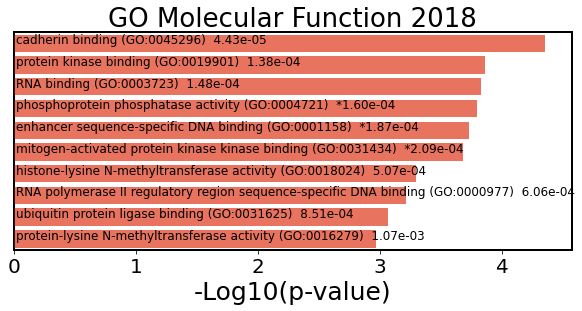

In [39]:
for i in enrichment_libraries:
    results = enrich(i, user_list_id, short_id)
    final_output_file_names = ["%s.png"%i]
    enrichr_figure(results[0],results[1],results[2],final_output_file_names, [i],"png", "tomato")

In [40]:
display(Markdown('Access your complete Enrichment results here: ' + str('https://amp.pharm.mssm.edu/Enrichr/enrich?dataset='+ short_id)))

Access your complete Enrichment results here: https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=7418d5029b8764fbc344c8c4b64727ef